In [1]:
import pickle, torch
from model_t4 import T4Transformer
from t4 import T4tokenizer
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from transformers import BertTokenizer, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

/home/apassadaki/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
name = 'admitos'
vocab_total_dii_vocab = f'/data/admitosstorage/Phase_2/data_phase2/{name.capitalize()}_way/Vocabs/{name}_dii_vocab.pkl'
vocab_total_sis_vocab = f'/data/admitosstorage/Phase_2/data_phase2/{name.capitalize()}_way/Vocabs/{name}_sis_vocab.pkl'
vocab_combined = f'/data/admitosstorage/Phase_2/data_phase2/{name.capitalize()}_way/Vocabs/all_{name}_vocab.pkl'

with open(vocab_total_dii_vocab, 'rb') as f:
    dii_vocab = pickle.load(f)

with open(vocab_total_sis_vocab, 'rb') as f:
    sis_vocab = pickle.load(f)

with open(vocab_combined, 'rb') as f:
    total_vocab = pickle.load(f)

print("The input-captions vocabulary is: ", len(dii_vocab))
print("The target-stories vocabulary is: ", len(sis_vocab))
print("The combined vocabulary is: ", len(total_vocab))

The input-captions vocabulary is:  32745
The target-stories vocabulary is:  34603
The combined vocabulary is:  49535


In [6]:
import json, random

train_path1 = '/data/admitosstorage/Phase_2/data_phase2/new_train_dataset1.json'
val_path1 = '/data/admitosstorage/Phase_2/data_phase2/new_val_dataset1.json'
test_path1 = 'C:/Users/admitos/Desktop/ThesisUU/Phase_2/data_phase2/new_test_dataset1.json'

# with open(train_path1, 'r', encoding='utf-8') as f:
#     my_new_train_dataset = dict(list(json.load(f).items())[:-1]) # We dont want to load the title 

# with open(val_path1, 'r', encoding='utf-8') as f:
#     my_new_val_dataset = dict(list(json.load(f).items())[:-1]) # We dont want to load the title 

with open(test_path1, 'r', encoding='utf-8') as f:
    my_new_test_dataset = dict(list(json.load(f).items())[:-1]) # We dont want to load the title  


In [4]:
use_bert = True
if use_bert:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    vocabulary_size_input = len(tokenizer.vocab) # BERT's vocabulary size
    vocabulary_size_target = len(tokenizer.vocab) # BERT's vocabulary size
else:
    tokenizer = T4tokenizer(total_vocab)
    vocabulary_size_input = len(tokenizer.get_vocab())
    vocabulary_size_target = len(tokenizer.get_vocab()) 

print(vocabulary_size_input, vocabulary_size_target)
embedding_dim = 512 
number_layers = 8
number_heads = 8
feed_forward_dim = 2048
my_device = torch.device('cuda:1')
print("DEVICE USED: ", my_device)
model = T4Transformer(vocab_size_input=vocabulary_size_input, vocab_size_target=vocabulary_size_target, d_model=embedding_dim, num_layers=number_layers, 
                        num_heads=number_heads, d_ff=feed_forward_dim, dropout=0.1, pad_token=0, device=my_device)
model.load_state_dict(torch.load(f'/data/admitosstorage/Phase_2/trained_models/seq/model_combined_MLM_SP_e30.pt', map_location=my_device))

30522 30522
DEVICE USED:  cuda:1


<All keys matched successfully>

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
criterion = CrossEntropyLoss(ignore_index=-100)
print("The trainable parameters of the model are: ", count_parameters(model))
model = model.to(my_device)

The trainable parameters of the model are:  105763642


In [6]:
if use_bert: 
    path_train_a = f'/data/admitosstorage/Phase_2/data_phase2/Combined/train_caps_1.pkl'
    path_train_b = f'/data/admitosstorage/Phase_2/data_phase2/Combined/train_caps_2.pkl'
    path_train_c = f'/data/admitosstorage/Phase_2/data_phase2/Combined/train_caps_3.pkl'
    
    with open(path_train_a, 'rb') as f:
        tokenized_train_captions1 = pickle.load(f)
    
    with open(path_train_b, 'rb') as f:
        tokenized_train_captions2 = pickle.load(f)
    
    with open(path_train_c, 'rb') as f:
        tokenized_train_captions3 = pickle.load(f)
    
    path_val_a = f'/data/admitosstorage/Phase_2/data_phase2/Combined/val_caps_1.pkl'
    path_val_b = f'/data/admitosstorage/Phase_2/data_phase2/Combined/val_caps_2.pkl'
    path_val_c = f'/data/admitosstorage/Phase_2/data_phase2/Combined/val_caps_3.pkl'
    
    with open(path_val_a, 'rb') as f:
        tokenized_val_captions1 = pickle.load(f)
    
    with open(path_val_b, 'rb') as f:
        tokenized_val_captions2 = pickle.load(f)
    
    with open(path_val_c, 'rb') as f:
        tokenized_val_captions3 = pickle.load(f)
        
    path_test_a = f'/data/admitosstorage/Phase_2/data_phase2/Combined/test_caps_1.pkl'
    path_test_b = f'/data/admitosstorage/Phase_2/data_phase2/Combined/test_caps_2.pkl'
    path_test_c = f'/data/admitosstorage/Phase_2/data_phase2/Combined/test_caps_3.pkl'
    
    with open(path_test_a, 'rb') as f:
        tokenized_test_captions1 = pickle.load(f)
    
    with open(path_test_b, 'rb') as f:
        tokenized_test_captions2 = pickle.load(f)
    
    with open(path_test_c, 'rb') as f:
        tokenized_test_captions3 = pickle.load(f)
    
    path_train_stories = f'/data/admitosstorage/Phase_2/data_phase2/Combined/train_stories.pkl'
    path_val_stories = f'/data/admitosstorage/Phase_2/data_phase2/Combined/val_stories.pkl'
    path_test_stories = f'/data/admitosstorage/Phase_2/data_phase2/Combined/test_stories.pkl'
    
    with open(path_train_stories, 'rb') as f:
        tokenized_train_stories = pickle.load(f)
    
    with open(path_val_stories, 'rb') as f:
        tokenized_val_stories = pickle.load(f)
    
    with open(path_test_stories, 'rb') as f:
        tokenized_test_stories = pickle.load(f)


class CustomDataset(Dataset):
    def __init__(self, entries, references):
        self.entries = entries
        self.references = references

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        item = {}
        item['caption'] = self.entries[idx]
        item['story'] = self.references [idx] 
        return item

        
def my_collate_fn(batch):
    input_ids = [item['caption'].transpose(0,1) for item in batch]
    target_ids = [item['story'].transpose(0,1) for item in batch]
    
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=0)
    target_ids_padded = pad_sequence(target_ids, batch_first=True, padding_value=0)

    final_input_ids = [item.transpose(0,1) for item in input_ids_padded]
    final_labels = [item.transpose(0,1) for item in target_ids_padded]

    return {'caption_ids': final_input_ids, 'story_ids': final_labels}

def plot_losses(list_of_losses, mylabel):
    plt.clf()
    iterations = range(1, len(list_of_losses) + 1)
    plt.plot(iterations, list_of_losses, color='blue', label=mylabel)
    plt.title(f'{mylabel} Over Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    merged_label = mylabel.replace(" ", "_")
    plt.savefig(f'./plots/phase2/auto/{merged_label}_plot.png')

In [7]:
if not use_bert:
    phase2_path_train_a = f'/data/admitosstorage/Phase_2/data_phase2/Combined/t4tok_train_caps.pkl'
    phase2_path_train_b = f'/data/admitosstorage/Phase_2/data_phase2/Combined/t4tok_train_stories.pkl'
    
    with open(phase2_path_train_a, 'rb') as f:
        tokenized_train_captions1 = pickle.load(f)
    
    with open(phase2_path_train_b, 'rb') as f:
        tokenized_train_stories = pickle.load(f)
    
    phase2_path_val_a = f'/data/admitosstorage/Phase_2/data_phase2/Combined/t4tok_val_caps.pkl'
    phase2_path_val_b = f'/data/admitosstorage/Phase_2/data_phase2/Combined/t4tok_val_stories.pkl'
    
    with open(phase2_path_val_a, 'rb') as f:
        tokenized_val_captions1 = pickle.load(f)
    
    with open(phase2_path_val_b, 'rb') as f:
        tokenized_val_stories = pickle.load(f)
    
    phase2_path_test_a = f'/data/admitosstorage/Phase_2/data_phase2/Combined/t4tok_test_caps.pkl'
    phase2_path_test_b = f'/data/admitosstorage/Phase_2/data_phase2/Combined/t4tok_test_stories.pkl'
    
    with open(phase2_path_test_a, 'rb') as f:
        tokenized_test_captions1 =pickle.load(f)
    
    with open(phase2_path_test_b, 'rb') as f:
        tokenized_test_stories = pickle.load(f)

In [8]:
## Prepareing Train Loaders 
b_s = 8
train_dataset1 = CustomDataset(tokenized_train_captions1, tokenized_train_stories)
train_loader1 = DataLoader(train_dataset1, batch_size=b_s, shuffle=False, collate_fn=my_collate_fn)

if use_bert:
    train_dataset2 = CustomDataset(tokenized_train_captions2, tokenized_train_stories)
    train_loader2 = DataLoader(train_dataset2, batch_size=b_s, shuffle=False, collate_fn=my_collate_fn)
    
    train_dataset3 = CustomDataset(tokenized_train_captions3, tokenized_train_stories)
    train_loader3 = DataLoader(train_dataset3, batch_size=b_s, shuffle=False, collate_fn=my_collate_fn)

## Prepareing Validation Loaders 
val_dataset1 = CustomDataset(tokenized_val_captions1, tokenized_val_stories)
val_loader1 = DataLoader(val_dataset1, batch_size=b_s, shuffle=False, collate_fn=my_collate_fn)

if use_bert:
    val_dataset2 = CustomDataset(tokenized_val_captions2, tokenized_val_stories)
    val_loader2 = DataLoader(val_dataset2, batch_size=b_s, shuffle=False, collate_fn=my_collate_fn)
    
    val_dataset3 = CustomDataset(tokenized_val_captions3, tokenized_val_stories)
    val_loader3 = DataLoader(val_dataset3, batch_size=b_s, shuffle=False, collate_fn=my_collate_fn)

## Prepareing Test Loaders 
test_dataset1 = CustomDataset(tokenized_test_captions1, tokenized_test_stories)
test_loader1 = DataLoader(test_dataset1, batch_size=b_s, shuffle=False, collate_fn=my_collate_fn)

if use_bert:
    test_dataset2 = CustomDataset(tokenized_test_captions2, tokenized_test_stories)
    test_loader2 = DataLoader(test_dataset2, batch_size=b_s, shuffle=False, collate_fn=my_collate_fn)
    
    test_dataset3 = CustomDataset(tokenized_test_captions3, tokenized_test_stories)
    test_loader3 = DataLoader(test_dataset3, batch_size=b_s, shuffle=False, collate_fn=my_collate_fn)

for batch in train_loader1:
    print("Captions shape:", batch['caption_ids'][0].shape, batch['caption_ids'][1].shape)
    print("Stories shape: ", batch['story_ids'][0].shape, batch['story_ids'][0].shape)
    break

Captions shape: torch.Size([1, 79]) torch.Size([1, 79])
Stories shape:  torch.Size([1, 81]) torch.Size([1, 81])


In [9]:
def transform_before_model(batch):
    batch_caption_ids = torch.stack(batch['caption_ids']).squeeze(1).to(my_device)
    batch_story_ids = torch.stack(batch['story_ids']).squeeze(1).to(my_device)
    return batch_caption_ids, batch_story_ids

In [10]:
def mask_tokens(labels, tokenizer, mlm_probability=0.15):
    inputs = labels.clone()
    labels = labels.clone()

    probability_matrix = torch.full(labels.shape, mlm_probability)
    special_tokens_mask = [tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  # Only compute loss on masked tokens

    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    indices_random = torch.bernoulli(torch.full(labels.shape, 0.1)).bool() & masked_indices & ~indices_replaced
    #print(indices_random)
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    #print(random_words)
    inputs[indices_random] = random_words[indices_random]
    #print(inputs)

    return inputs.to(my_device), labels.to(my_device)

# Example data
captions = "The tree is very healthy because of the water. [SEP] A white Ford Mustang is behind a fence and parked next to another car. [SEP] A round multi-story brick building photo taken from ground level [SEP] A flower with a purple shade in the garden. [SEP] A bird sits on the wire next to a star-shaped decoration."
stories = "To its rigid sharp trees. Its not uncommon to see vintage cars in such an odd city like this. This town has personality, from its large cylindrical buildings. To flowers that resemble pandas mixed with ducks. To the star of David that crows use to perch on."

# Tokenize
captions_tokens = tokenizer.encode(captions, return_tensors="pt")
stories_tokens = tokenizer.encode(stories, return_tensors="pt")

# Generate masked inputs and labels
masked_inputs, masked_labels = mask_tokens(stories_tokens, tokenizer)
print(masked_inputs)
print(masked_labels)


tensor([[  101,  2000,  2049, 11841,  4629,  3628,  1012,  2049,  2025, 13191,
          2000,   103, 13528,  3765,  1999,  2107,   103,  5976,  2103,  2066,
          2023,  1012,  2023,  2237,  2038,  6180,  1010,   103,  2049,   103,
         18797,  3121,  1012,  2000,  4870,  2008, 13014, 25462,  2015,   103,
           103,   103,  1012,  2000,  1996,  2732,  1997,  2585,  2008, 21623,
           103,  2000, 21836,  2006,  1012,   102]], device='cuda:1')
tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  2156,  -100,  -100,  -100,  -100,  2019,  -100,  -100,  -100,
          -100,  -100,  -100,  2237,  2038,  -100,  1010,  2013,  -100,  2312,
         18797,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  3816,
          2007, 14875,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          2224,  -100,  -100,  -100,  -100,  -100]], device='cuda:1')


In [11]:
def pad_to_same_size(tensor1, tensor2):
    # Get the shapes of the two tensors
    shape1 = tensor1.shape
    shape2 = tensor2.shape
    
    # Determine the maximum size along each dimension
    max_rows = max(shape1[0], shape2[0])
    max_cols = max(shape1[1], shape2[1])
    
    # Create new tensors with the maximum size, initialized with zeros
    padded_tensor1 = torch.zeros((max_rows, max_cols), dtype=tensor1.dtype)
    padded_tensor2 = torch.zeros((max_rows, max_cols), dtype=tensor2.dtype)
    
    # Copy the values from the original tensors to the new tensors
    padded_tensor1[:shape1[0], :shape1[1]] = tensor1
    padded_tensor2[:shape2[0], :shape2[1]] = tensor2
    
    return padded_tensor1.to(my_device), padded_tensor2.to(my_device)


In [12]:
def permute_sentences(stories, tokenizer):
    permuted_stories = []
    for story in stories:
        # Decode the story to get the text
        story_text = tokenizer.decode(story, skip_special_tokens=True)
        #print(len(story_text.split()))
        # Split the story into sentences
        sentences = story_text.split('.')
        # Remove empty strings
        sentences = [s for s in sentences if s]
        # Shuffle the sentences
        random.shuffle(sentences)
        # Join the sentences back into a single string
        permuted_story = '. '.join(sentences) + '.'
        # Encode the permuted story back to tokens
        permuted_stories.append(tokenizer.encode(permuted_story, add_special_tokens=True))
    
    # Pad the permuted stories to the same length
    max_length = max(len(s) for s in permuted_stories)
    permuted_stories = [s + [tokenizer.pad_token_id] * (max_length - len(s)) for s in permuted_stories]

    return torch.tensor(permuted_stories).to(my_device)

# Example usage:
for j,btch in enumerate(train_loader2):
    caps, stories = transform_before_model(btch)
    permuted_stories = permute_sentences(stories, tokenizer)
    print("Before: ", stories.shape, " / ", permuted_stories.shape)
    if not stories.shape == permuted_stories.shape:
        stories, permuted_stories = pad_to_same_size(stories, permuted_stories)
        print("After: ", stories.shape, " / ", permuted_stories.shape)
        #print(len(stories[0].nonzero().squeeze()))
        #print(len(permuted_stories[0].nonzero().squeeze()))
    print("-----------------------------------------------------------------------------")
    if j==5:
        break


Before:  torch.Size([8, 81])  /  torch.Size([8, 81])
-----------------------------------------------------------------------------
Before:  torch.Size([8, 77])  /  torch.Size([8, 78])
After:  torch.Size([8, 78])  /  torch.Size([8, 78])
-----------------------------------------------------------------------------
Before:  torch.Size([8, 93])  /  torch.Size([8, 94])
After:  torch.Size([8, 94])  /  torch.Size([8, 94])
-----------------------------------------------------------------------------
Before:  torch.Size([8, 70])  /  torch.Size([8, 70])
-----------------------------------------------------------------------------
Before:  torch.Size([8, 65])  /  torch.Size([8, 65])
-----------------------------------------------------------------------------
Before:  torch.Size([8, 90])  /  torch.Size([8, 90])
-----------------------------------------------------------------------------


In [ ]:
xxx = input("How to train? [MLM/SP/other]: ")
num_epochs = 30
train_loss_per_epoch = []
val_loss_per_epoch = []
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    print(" ############################################## Training loop ############################################### ")
    if epoch <= 9:
        train_loader, val_loader = train_loader1, val_loader1
    elif epoch>=10 and epoch < 20:
        train_loader, val_loader = train_loader2, val_loader2
    else:
        train_loader, val_loader = train_loader3, val_loader3

    for batch_idx, batch in enumerate(train_loader):  

        caps, stories = transform_before_model(batch)
        optimizer.zero_grad()
        if xxx.upper() == 'MLM':
            masked_dec_inputs, masked_labels = mask_tokens(stories.to('cpu'), tokenizer)
            #outputs = model(caps, stories[:,:-1])
            outputs = model(caps, masked_dec_inputs)
            #new_outputs = outputs[:,1:,:]
            #loss = criterion(outputs.contiguous().view(-1, vocabulary_size_target), stories[:, 1:].contiguous().view(-1))
            shift_outputs = outputs[..., :-1, :].contiguous()
            shift_labels = masked_labels[..., 1:].contiguous()
            loss = criterion(shift_outputs.view(-1, shift_outputs.size(-1)), shift_labels.view(-1))
        elif xxx.upper() == 'SP':
            permuted_stories = permute_sentences(stories.to('cpu'), tokenizer)
            if not stories.shape == permuted_stories.shape:
                stories, permuted_stories = pad_to_same_size(stories, permuted_stories)
            outputs = model(caps, permuted_stories)
            shift_outputs = outputs[..., :-1, :].contiguous()
            shift_labels = stories[..., 1:].contiguous()
            loss = criterion(shift_outputs.view(-1, shift_outputs.size(-1)), shift_labels.view(-1))
        else:
            outputs = model(caps, stories[:, :-1])
            #shift_outputs = outputs[..., :-1, :].contiguous()
            print(outputs.shape)
            print(outputs.view(-1, outputs.size(-1)).shape)
            print(stories[..., 1:].shape)
            print(stories[..., 1:].contiguous().view(-1).shape)    
            loss = criterion(outputs.contiguous().view(-1, outputs.size(-1)), stories[..., 1:].contiguous().view(-1))
            
            
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        break
        if batch_idx%50 == 0: 
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Running Train Loss: {loss.item():.4f}')

    avg_train_loss = epoch_train_loss/len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Train Loss: {avg_train_loss:.4f}')
    train_loss_per_epoch.append(avg_train_loss)
    break
    print("------------------------------------------ Validation loop ------------------------------------------------")
    epoch_val_loss = 0.0
    model.eval()  #
    with torch.no_grad():  
        for batch_idx, batch in enumerate(val_loader): 
            caps, stories = transform_before_model(batch)
            if xxx.upper() == 'MLM':
                masked_dec_inputs, masked_labels = mask_tokens(stories.to('cpu'), tokenizer)
                #outputs = model(caps, stories[:,:-1])
                outputs = model(caps, masked_dec_inputs)
                
                #new_output = output[:,1:,:]
                #val_loss = criterion(outputs.contiguous().view(-1, vocabulary_size_target), stories[:, 1:].contiguous().view(-1))
                shift_outputs = outputs[..., :-1, :].contiguous()
                shift_labels = masked_labels[..., 1:].contiguous()
                val_loss = criterion(shift_outputs.view(-1, shift_outputs.size(-1)), shift_labels.view(-1))
            elif xxx.upper() == 'SP':
                permuted_stories = permute_sentences(stories.to('cpu'), tokenizer)
                if not stories.shape == permuted_stories.shape:
                    stories, permuted_stories = pad_to_same_size(stories, permuted_stories)
                outputs = model(caps, permuted_stories)
                shift_outputs = outputs[..., :-1, :].contiguous()
                shift_labels = stories[..., 1:].contiguous()
                val_loss = criterion(shift_outputs.view(-1, shift_outputs.size(-1)), shift_labels.view(-1))
            else:
                outputs = model(caps, stories[:, :-1])
                val_loss = criterion(outputs.contiguous().view(-1, shift_outputs.size(-1)), stories[..., 1:].contiguous().view(-1))

            epoch_val_loss += val_loss.item()
            if batch_idx%10 == 0: 
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(val_loader)}], Running Val Loss: {val_loss.item():.4f}')

    avg_val_loss = epoch_val_loss/len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Val Loss: {avg_val_loss:.4f}")
    val_loss_per_epoch.append(avg_val_loss)
    if (epoch+1)%5==0:
        torch.save(model.state_dict(), f'/data/admitosstorage/Phase_2/trained_models/seq/trained_model_MLM_SP_Norm_e{epoch+1}.pt')

print()
print("Training finished!")

How to train? [MLM/SP/other]:  o


 ############################################## Training loop ############################################### 
torch.Size([8, 80, 30522])
torch.Size([640, 30522])
torch.Size([8, 80])
torch.Size([640])
Epoch [1/30], Average Train Loss: 0.0002

Training finished!


In [ ]:
num_epochs = 3
train_loss_per_epoch = []
val_loss_per_epoch = []
start_token_id = tokenizer.cls_token_id
eos_token_id = tokenizer.sep_token_id
for epoch in range(num_epochs):
    print("------------------------------------------ Training loop ------------------------------------------------")
    epoch_train_loss = 0.0
    model.train()  
    
    train_loss_per_iter = []
    for batch_idx, batch in tqdm(enumerate(train_loader1), total=len(train_loader1),  desc="Processing Train items", ncols=100):
        caps, stories = transform_before_model(batch)
        model.zero_grad()
        generated_sequences = torch.full((stories.size(0), 1), start_token_id, dtype=torch.long).to(my_device)
        generation_train_loss = 0.0
        enc_mask = model.create_padding_mask(caps)
        enc_out = model.encode(caps, enc_mask)
        for k in range(stories.size(1)):        
            look_ahead_mask = model.create_look_ahead_mask(generated_sequences.size(1)).to(my_device)
            combined_mask = torch.max(model.create_padding_mask(generated_sequences), look_ahead_mask)
            dec_input = generated_sequences
            dec_out = model.decode(dec_input, enc_out, enc_mask, combined_mask)
            output = model.fc_out(dec_out)
            probs = F.softmax(output[:, -1, :], dim=-1) # put 0 in the 2nd dim for in the 3d 
            next_token = torch.argmax(probs, dim=-1).unsqueeze(-1)
            generated_sequences = torch.cat((generated_sequences, next_token), dim=1)
            generation_train_loss += criterion(output[:,-1,:].contiguous().view(-1,vocabulary_size_target), stories[:, k].contiguous().view(-1)) # loss calculated per token generated
            #train_loss = criterion(output.contiguous().view(-1,vocabulary_size_target), stories[:, 0:k+1].squeeze(1).contiguous().view(-1)) # loss for the whole sequence
            #print(f"Epoch: {epoch+1}, Iteration: {batch_idx+1}/{len(train_loader1)}, Generation step: {k+1}/{stories.size(1)}, Step Loss: {train_loss.item():.5f}")

        avg_running_train_loss = generation_train_loss/stories.size(1)
        generation_train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        #print(f"Epoch: {epoch+1}, Iteration: {batch_idx+1}/{len(train_loader1)}, Generation step: {k+1}/{stories.size(1)}, Step Loss: {train_loss.item():.5f}")
        torch.cuda.empty_cache()
        train_loss_per_iter.append(generation_train_loss.item())
        epoch_train_loss += generation_train_loss.item()
        if batch_idx%5==0:
            print(f"Epoch: {epoch+1}, Iteration {batch_idx+1}/{len(train_loader1)}, Train Iteration Loss: {generation_train_loss.item():.5f}")
            # saver = int(it//260)
            # torch.save(model.state_dict(), f'/data/admitosstorage/Phase_2/trained_models/auto/model_bert_yingjin_e{epoch+1}_v{saver}.pt')
        
    avg_epoch_train_loss = epoch_train_loss/len(train_loader1)
    print(f"Epoch {epoch+1}, Average Train Epoch Loss: {avg_epoch_train_loss:.5f}")
    train_loss_per_epoch.append(avg_epoch_train_loss)

    print("------------------------------------------ Validation loop ------------------------------------------------")
    epoch_val_loss = 0.0
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for validation
        val_loss_per_iter = []
        for batch_idx, batch in tqdm(enumerate(val_loader1), total=len(val_loader1), desc="Processing Validation items", ncols=100):
            caps, stories = transform_before_model(batch)
            generated_sequences = torch.full((stories.size(0), 1), start_token_id, dtype=torch.long).to(my_device)
            generation_val_loss = 0.0
            enc_mask = model.create_padding_mask(caps)
            enc_out = model.encode(caps, enc_mask)
            for k in range(stories.size(1)):
                look_ahead_mask = model.create_look_ahead_mask(generated_sequences.size(1)).to(my_device)
                combined_mask = torch.max(model.create_padding_mask(generated_sequences), look_ahead_mask)
                dec_input = generated_sequences
                dec_out = model.decode(dec_input, enc_out, enc_mask, combined_mask)
                output = model.fc_out(dec_out)             
                probs = F.softmax(output[:, -1, :], dim=-1) # put 0 in the 2nd dim for in the 3d 
                next_token = torch.argmax(probs, dim=-1).unsqueeze(-1)
                generated_sequences = torch.cat((generated_sequences, next_token), dim=1)
                generation_val_loss = criterion(output[:,-1,:].contiguous().view(-1,vocabulary_size_target), stories[:, k].contiguous().view(-1)) # loss calculated per token generated
                #val_loss = criterion(output.contiguous().view(-1,vocabulary_size_target), stories[:, 0:k+1].squeeze(1).contiguous().view(-1)) # loss for the whole sequence
                #print(f"Epoch: {epoch+1}, Iteration: {batch_idx+1}/{len(val_loader1)}, Generation step: {k+1}/{stories.size(1)}, Step Loss: {val_loss.item():.5f}")
            
            torch.cuda.empty_cache()             
            avg_running_val_loss = generation_val_loss/stories.size(1)
            val_loss_per_iter.append(generation_val_loss.item())
            epoch_val_loss += generation_val_loss.item()
            if batch_idx%5==0:
                print(f"Epoch: {epoch+1}, Iteration {batch_idx+1}/{len(val_loader1)}, Val Iteration Loss: {generation_val_loss.item():.5f}")

        avg_epoch_val_loss = epoch_val_loss/len(val_loader1)
        print(f"Epoch {epoch+1}, Average Validation Epoch Loss: {avg_epoch_val_loss:.5f}")
        val_loss_per_epoch.append(avg_epoch_val_loss)

------------------------------------------ Training loop ------------------------------------------------


Processing Train items:   0%|                                    | 1/6643 [00:02<3:52:19,  2.10s/it]

Epoch: 1, Iteration 1/6643, Train Iteration Loss: 591.03607


Processing Train items:   0%|                                    | 6/6643 [00:14<4:46:23,  2.59s/it]

Epoch: 1, Iteration 6/6643, Train Iteration Loss: 857.70709


Processing Train items:   0%|                                   | 11/6643 [00:26<4:26:53,  2.41s/it]

Epoch: 1, Iteration 11/6643, Train Iteration Loss: 784.86249


Processing Train items:   0%|                                   | 16/6643 [00:39<4:47:14,  2.60s/it]

Epoch: 1, Iteration 16/6643, Train Iteration Loss: 544.90808


Processing Train items:   0%|                                   | 21/6643 [00:52<5:01:32,  2.73s/it]

Epoch: 1, Iteration 21/6643, Train Iteration Loss: 698.54980


Processing Train items:   0%|▏                                  | 26/6643 [01:07<5:18:48,  2.89s/it]

Epoch: 1, Iteration 26/6643, Train Iteration Loss: 760.61139


Processing Train items:   0%|▏                                  | 27/6643 [01:12<4:58:03,  2.70s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 1 has a total capacity of 10.75 GiB of which 2.44 MiB is free. Including non-PyTorch memory, this process has 10.75 GiB memory in use. Of the allocated memory 9.96 GiB is allocated by PyTorch, and 612.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

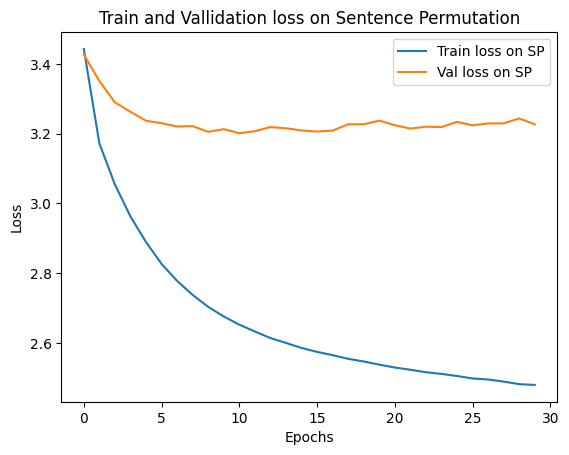

In [232]:
# train_loss_per_epoch_sp = train_loss_per_epoch
# val_loss_per_epoch_sp = val_loss_per_epoch
plt.title("Train and Vallidation loss on Sentence Permutation")
plt.plot(train_loss_per_epoch_sp, label='Train loss on SP')
plt.plot(val_loss_per_epoch_sp, label='Val loss on SP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

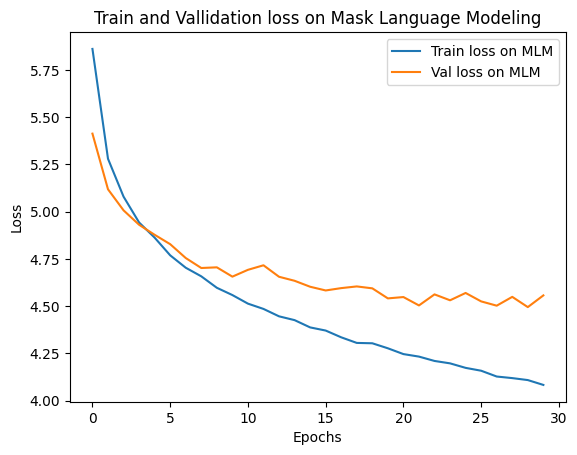

In [233]:
# train_loss_per_epoch_mlm = train_loss_per_epoch
# val_loss_per_epoch_mlm = val_loss_per_epoch
plt.title("Train and Vallidation loss on Mask Language Modeling")
plt.plot(train_loss_per_epoch_mlm, label='Train loss on MLM')
plt.plot(val_loss_per_epoch_mlm, label='Val loss on MLM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

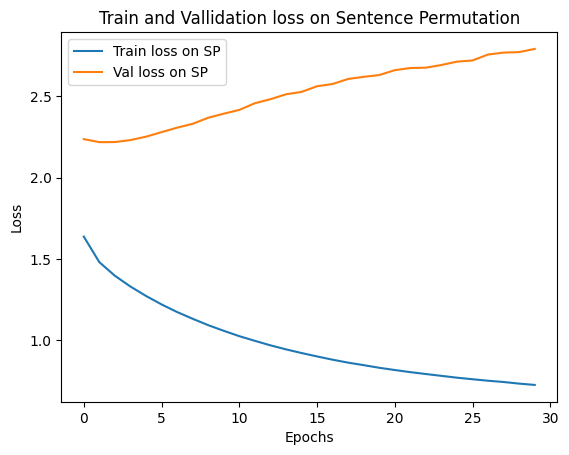

In [263]:
train_loss_per_epoch_norm = train_loss_per_epoch
val_loss_per_epoch_norm = val_loss_per_epoch
plt.title("Train and Vallidation loss on Sentence Permutation")
plt.plot(train_loss_per_epoch_norm, label='Train loss on SP')
plt.plot(val_loss_per_epoch_norm, label='Val loss on SP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

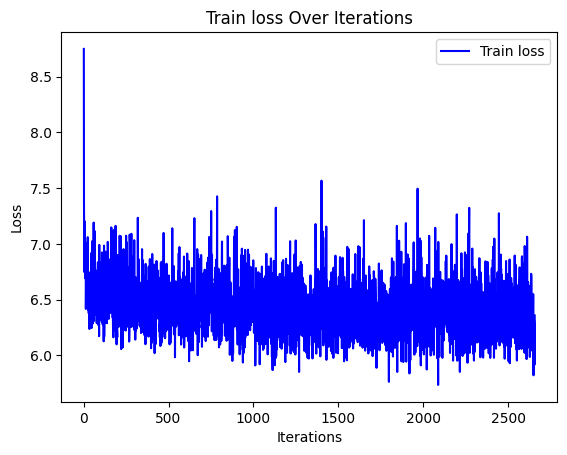

In [41]:
plot_losses(train_loss_per_iter, "Train loss")
#plot_losses(val_loss_per_iter, "Validation loss")

In [13]:
embedding_dim = 512 
number_layers = 8
number_heads = 8
feed_forward_dim = 2048
my_device = torch.device('cuda:1')
print("DEVICE USED: ", my_device)
model = T4Transformer(vocab_size_input=vocabulary_size_input, vocab_size_target=vocabulary_size_target, d_model=embedding_dim, num_layers=number_layers, 
                        num_heads=number_heads, d_ff=feed_forward_dim, dropout=0.1, pad_token=0, device=my_device)
#model.load_state_dict(torch.load(f'/data/admitosstorage/Phase_2/trained_models/seq/model_combined_with_MLM_20.pt'))
#model.load_state_dict(torch.load(f'/data/admitosstorage/Phase_2/trained_models/seq/model_combined_MLM_SP_e20.pt'))
model.load_state_dict(torch.load(f'/data/admitosstorage/Phase_2/trained_models/seq/trained_model_MLM_SP_Norm_e5.pt'))
model = model.to(my_device)

DEVICE USED:  cuda:1


In [14]:
rand_choice = random.randint(0,len(my_new_train_dataset))
new_entry = list(my_new_train_dataset.items())[rand_choice][1]
new_captions = new_entry[0]
new_story = new_entry[1]
input_text = ' [SEP] '.join(new_captions)
print(input_text)
print()
print(new_story)
if use_bert: 
    caption_ids = tokenizer(input_text, return_tensors="pt").input_ids
    target_ids = tokenizer(new_story, return_tensors="pt").input_ids
else:
    caption_ids = tokenizer.encode(input_text, return_tensors="pt") 
    target_ids = tokenizer.encode(new_story, return_tensors="pt")
caption_ids = caption_ids.to(my_device)
print()
print(caption_ids.shape)
print(target_ids.shape)

Two men carrying something wood up the stairs. [SEP] A person wearing blue jeans has an injured middle finger. [SEP] A truck blocks the way for any through traffic motorist. [SEP] A room with two desks and two windows. [SEP] A group of objects that are in a garage.

It takes some hard work to get the furniture up the stairs. There is a small accident in the process. The team finally gets to move into their new office. But it is all worth it to see the new office set up! They are all packed up and ready to go!

torch.Size([1, 58])
torch.Size([1, 59])


In [26]:
# Generate narrative story
with torch.no_grad():
    story = model.generate(input_text, tokenizer, target_stories=new_story, teacher_forcing=True)

print(story)

On generation step:  0
On generation step:  1
On generation step:  2
On generation step:  3
On generation step:  4
On generation step:  5
On generation step:  6
. groups groups. friends groups


## A trial with another model (from pytorch)

In [8]:
import numpy as np
def find_problematic_entries(dataset):
    problematic_keys = []
    for key, text in list(dataset.items())[:-1]:
        if len(text[0])<5 or len(text[1])<5: 
            if len(text[0])<5:
                problematic_keys.append(key)
            if len(text[1])<5:
                problematic_keys.append(key)
    return problematic_keys

In [9]:
phase2_path_train = '/data/admitosstorage/Phase_2/data_phase2/train_dataset_all_v1.json'
phase2_path_val = '/data/admitosstorage/Phase_2/data_phase2/val_dataset_all_v1.json'
phase2_path_test = '/data/admitosstorage/Phase_2/data_phase2/test_dataset_all_v1.json'

with open(phase2_path_train, 'r', encoding='utf-8') as f:
    #train_dataset = json.load(f) 
    train_dataset = dict(list(json.load(f).items())[:-1]) # We dont want to load the title 

with open(phase2_path_val, 'r', encoding='utf-8') as f:
    #val_dataset = json.load(f)
    val_dataset = dict(list(json.load(f).items())[:-1]) # We dont want to load the title 

with open(phase2_path_test, 'r', encoding='utf-8') as f:
    #test_dataset = json.load(f)
    test_dataset = dict(list(json.load(f).items())[:-1]) # We dont want to load the title  

print("The non-five entries on the train dataset are: ", end="")
print(len(find_problematic_entries(train_dataset)))
print(f'The precentage of these entries over the train dataset is {np.round(len(find_problematic_entries(train_dataset))/len(train_dataset)*100, 2)}% \n')

print("The non-five entries on the validation dataset are: ", end="")
print(len(find_problematic_entries(val_dataset)))
print(f'The precentage of these entries over the validation dataset is {np.round(len(find_problematic_entries(val_dataset))/len(val_dataset)*100, 2)}% \n')

print("The non-five entries on the test dataset are: ", end="")
print(len(find_problematic_entries(test_dataset)))
print(f'The precentage of these entries over the test dataset is {np.round(len(find_problematic_entries(test_dataset))/len(test_dataset)*100, 2)}%')

The non-five entries on the train dataset are: 278
The precentage of these entries over the train dataset is 1.04% 

The non-five entries on the validation dataset are: 26
The precentage of these entries over the validation dataset is 0.78% 

The non-five entries on the test dataset are: 20
The precentage of these entries over the test dataset is 0.6%


In [10]:
import torch, re
import torch.nn as nn
import torch.optim as optim
import math, random
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [11]:
def combine_sent_stories(old_dataset):
    source_inputs = [value[0] for value in old_dataset.values()]
    sent_targets = [value[1] for value in old_dataset.values()]
    # choose the first of the three captions (caps[0])
    new_keys = [key for key in old_dataset.keys() if len(old_dataset[key][0])==5 and len(old_dataset[key][1])==5] # choose only the 5-lengthy stories
    input_captions = [[caps[0] for caps in image_caps] for image_caps in source_inputs if len(image_caps)==5] 
    target_stories = [' '.join(sent_targets[i]) for i in range(len(sent_targets)) if len(sent_targets[i])==5]

    print("The number of new keys are:", len(new_keys))
    print("Number of captions: ", len(input_captions))
    print("Number of stories: ", len(target_stories))

    assert len(new_keys) == len(input_captions) == len(target_stories), \
    f"AssertionError: The lengths are not the same! new_keys: {len(new_keys)}, input_captions: {len(input_captions)}, target_stories: {len(target_stories)}"
    print("All lengths are equal.")

    new_dataset = {}
    for j,key in enumerate(new_keys):
        new_dataset[key] = (input_captions[j],target_stories[j])

    new_dataset['junk'] = ("junk1","junk2") 
    return new_dataset

new_train_dataset = combine_sent_stories(train_dataset)
print()
new_val_dataset = combine_sent_stories(val_dataset)
print()
new_test_dataset = combine_sent_stories(test_dataset)
print("----------------------------------------------------")
print("The length of the new Train Dataset is:", len(new_train_dataset))
print("The length of the new Validation Dataset is:", len(new_val_dataset))
print("The length of the new Test Dataset is:", len(new_test_dataset))

The number of new keys are: 26570
Number of captions:  26570
Number of stories:  26570
All lengths are equal.

The number of new keys are: 3319
Number of captions:  3319
Number of stories:  3319
All lengths are equal.

The number of new keys are: 3338
Number of captions:  3338
Number of stories:  3338
All lengths are equal.
----------------------------------------------------
The length of the new Train Dataset is: 26571
The length of the new Validation Dataset is: 3320
The length of the new Test Dataset is: 3339


In [12]:
list(new_test_dataset.items())[0]

('47142',
 (['An image of a boat named Jascon 27',
   'a very large building with evenly spaced barred windows.',
   'A boxy white ship is tied to a wharf.',
   'An industrial structure covered in rust and stairs',
   'the side of a metal building with two open windows and a cloudy sky'],
  'The name of the ship was Jascon 27. We took the day to visit an old abandoned ship. It had been used in war for many of years. It was so old it was starting to rust. Overall, it was a great learning experience.'))

In [26]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float()*(-math.log(10000.0))/dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

In [27]:
class Transformer(nn.Module):
    """
    Model from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/p/c80afbc9ffb1/
    """
    # Constructor
    def __init__(self,num_tokens,dim_model,num_heads,num_encoder_layers,num_decoder_layers,dropout_p,pad_token):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model
        self.pad_token = pad_token
        
        # LAYERS
        self.positional_encoder = PositionalEncoding(dim_model=dim_model, dropout_p=dropout_p, max_len=5000)
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.transformer = nn.Transformer(d_model=dim_model,nhead=num_heads,num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,dropout=dropout_p, batch_first=True)
        self.out = nn.Linear(dim_model, num_tokens)

    def forward(self, src, tgt, src_mask, tgt_mask):
        # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        src = self.embedding(src)*math.sqrt(self.dim_model)
        tgt = self.embedding(tgt)*math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)
     
        # we permute to obtain size (sequence length, batch_size, dim_model),
        # src = src.permute(1, 0, 2)
        # tgt = tgt.permute(1, 0, 2)

        # Transformer blocks - Out size = (sequence_length, batch_size, num_tokens)
        # With batch_first = True it is: (batch_size, sequence_length, num_tokens)
        transformer_out = self.transformer(src, tgt, src_mask=src_mask, tgt_mask=tgt_mask)
        out = self.out(transformer_out)

        return out

    def get_src_tgt_mask(self, size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        
        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]
        
        return mask
    
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        return (matrix == pad_token)

In [28]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
start_token_id = tokenizer.cls_token_id
eos_token_id = tokenizer.sep_token_id

In [29]:
# def predict(model, input_sequence, target_sequence, SOS_token, EOS_token, max_length=150, teacher_forcing=False):
#     """
#     Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
#     Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
#     """
#     model.eval()
#     y_input = torch.tensor([[SOS_token]], dtype=torch.long).to(device)
#     gen_seq = torch.tensor([[SOS_token]], dtype=torch.long).to(device)
#     num_tokens = len(input_sequence[0])
#     src_mask = model.get_src_tgt_mask(input_sequence.size(1))
    
#     for k in range(max_length):
#         # Get source mask
#         tgt_mask = model.get_src_tgt_mask(y_input.size(1)).to(device)
#         pred = model(input_sequence, y_input, src_mask, tgt_mask)
        
#         next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability     
#         next_item = torch.tensor([[next_item]]).to(device)

#         # Concatenate previous input with predicted best word
#         gen_seq = torch.cat((y_input, next_item), dim=1)

#         # Concatenate previous input with actual token
#         if teacher_forcing and k%2==0: 
#             y_input = torch.cat((y_input, target_sequence[:,k:k+1]), dim=1)
#         else:
#             y_input = gen_seq

#         # Stop if model predicts end of sentence
#         if next_item.view(-1).item() == EOS_token:
#             break

#     return gen_seq.view(-1).tolist()

In [30]:
def beam_search(model, input_sequence, SOS_token, EOS_token, beam_width, max_length=149):
    device = next(model.parameters()).device  # Get device from model parameters

    # Initialize sequences with the <cls> token (or <s> token)
    y_input = torch.tensor([[SOS_token]], dtype=torch.long).to(device)
    gen_seq = torch.tensor([[SOS_token]], dtype=torch.long).to(device)

    # Initialize beams with initial sequence
    beams = [(gen_seq, 0)]  # List of (sequence, cumulative log probability)

    src_mask = model.get_src_tgt_mask(input_sequence.size(1))

    for k in range(max_length):
        new_beams = []
        for seq, score in beams:
            y_input = seq.to(device)
            tgt_mask = model.get_src_tgt_mask(y_input.size(1)).to(device)
            pred = model(input_sequence, y_input, src_mask, tgt_mask)

            # Get top beam_width predictions for each sequence
            topk = torch.topk(pred[:, -1, :], beam_width, dim=-1)
            topk_indices = topk.indices.squeeze(0)
            topk_scores = topk.values.squeeze(0)

            for i in range(beam_width):
                next_token = topk_indices[i].unsqueeze(0).unsqueeze(0)  # Shape: [1, 1]
                next_score = topk_scores[i].item()

                new_seq = torch.cat([seq, next_token], dim=-1)  # Append next token to sequence
                new_beams.append((new_seq, score + next_score))

        # Sort beams by score and keep top beam_width sequences
        new_beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]

        # Update beams with new sequences
        beams = new_beams

        # Check if all beams have ended with EOS_token
        all_ended = all(b[0][0, -1].item() == EOS_token for b in beams)
        if all_ended:
            break

    # Select the sequence with the highest score as the final generated sequence
    final_seq = max(beams, key=lambda x: x[1])[0]
    return final_seq.view(-1).tolist()

In [31]:
def predict(model, input_sequence, target_sequence, SOS_token, EOS_token, max_length=149, teacher_forcing=False, strategy='greedy', p=0.9):
    model.eval()
    
    def capitalize_story(input_story):
        # Capitalize the first letter of the entire story
        input_story = input_story.strip().capitalize()
        # Use regex to find all occurrences of a full stop followed by a space and a letter, and capitalize that letter
        input_story = re.sub(r'(\. )([a-z])', lambda match: match.group(1) + match.group(2).upper(), input_story)
        return input_story
        
    if strategy == 'beam_search':
        #beam_width = input("Please choose the beam width (Int from 1 to 5): ")
        beam_width = 3
        generated_sequence = beam_search(model, input_sequence, SOS_token, EOS_token, int(beam_width))
        story = tokenizer.decode(generated_sequence, skip_special_tokens=True)
        final_story = capitalize_story(story)  
        return generated_sequence, final_story
    
    y_input = torch.tensor([[SOS_token]], dtype=torch.long).to(device)
    gen_seq = torch.tensor([[SOS_token]], dtype=torch.long).to(device)
    src_mask = model.get_src_tgt_mask(input_sequence.size(1))
    
    def nucleus_sampling(logits, p):
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
        sorted_indices_to_remove = cumulative_probs > p
        sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
        sorted_indices_to_remove[:, 0] = 0
        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
        logits[indices_to_remove] = -float('Inf')
        return torch.multinomial(F.softmax(logits, dim=-1), 1).item()

    for k in range(max_length):
        tgt_mask = model.get_src_tgt_mask(y_input.size(1)).to(device)
        pred = model(input_sequence, y_input, src_mask, tgt_mask)
        
        if strategy == 'greedy':
            next_item = pred.topk(1)[1].view(-1)[-1].item()
        elif strategy == 'multinomial':
            next_item = torch.multinomial(F.softmax(pred[:, -1, :], dim=-1), 1).item()
        elif strategy == 'p-sampling':
            next_item = nucleus_sampling(pred[:, -1, :], p)
        else:
            raise ValueError("Unsupported decoding strategy")
        
        next_item = torch.tensor([[next_item]]).to(device)
        gen_seq = torch.cat((y_input, next_item), dim=1)
        
        if teacher_forcing and k % 2 == 0:
            y_input = torch.cat((y_input, target_sequence[:, k:k+1]), dim=1)
        else:
            y_input = gen_seq
        
        if next_item.view(-1).item() == EOS_token:
            break

    story_token_ids = gen_seq.view(-1).tolist()
    story = tokenizer.decode(story_token_ids, skip_special_tokens=True)
        
    final_story = capitalize_story(story)
    return story_token_ids, final_story

### Full Model

In [32]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
model = Transformer(num_tokens=30522, dim_model=512, num_heads=8, num_encoder_layers=6, num_decoder_layers=6, dropout_p=0.1, pad_token=0).to(device)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print("The trainable parameters of the model are: ", count_parameters(model))
model.load_state_dict(torch.load(f'/data/admitosstorage/Phase_2/trained_models/final_model_pytorch_all_e12.pt', map_location=device))

The trainable parameters of the model are:  75425594


<All keys matched successfully>

In [42]:
test_captions = [item[0] for item in list(new_test_dataset.values())[:-1]]
test_stories = [item[1] for item in list(new_test_dataset.values())[:-1]]

In [43]:
rand_choice = random.randint(0,len(test_stories))
rand_choice = 234
opted_captions = test_captions[rand_choice]
opted_story = test_stories[rand_choice]
input_text = ' [SEP] '.join(opted_captions)
print(input_text)
print()
print(opted_story)
caption_ids = tokenizer(input_text, return_tensors="pt").input_ids
target_ids = tokenizer(opted_story, return_tensors="pt").input_ids

a man and woman wearing black with painted school faces [SEP] A man in a hospital gown andbracelet clapping his hands. [SEP] A patient in his hospital gown outside getting some air. [SEP] A man that is wearing a weird outfit in the room. [SEP] all of the costumers stand together to show their creativity

Some of our costumes are really amazing today. We are having a party, and everyone has arrived. It is Halloween again, that is not an escaped medical patient. Check out all the cool costumes. We decided to take the party outside since it is so nice.


In [44]:
generated_story_ids, my_story = predict(model, caption_ids.to(device), target_ids.to(device), start_token_id, 
                                        eos_token_id, teacher_forcing=False, strategy='p-sampling')
print("The length of the generated story is: ", len(generated_story_ids))
print(my_story)
if len(full_model_stories) == 1:
    full_model_stories.pop()
full_model_stories.append(my_story)

The length of the generated story is:  92
It is always a great day to celebrate. We even have a small family room to sit together and talk about strangers. My mother got me a big card from dad as well. Even the kids have a chance to take pictures and their little girl taught me how to paint. It was my birthday and i hope my parents turn to join in the fun! my parents decided to take pictures at the end of the day and we had an awesome party.


In [48]:
rand_choice = random.randint(0,len(test_stories))
rand_choice = 748
opted_captions = test_captions[rand_choice]
opted_story = test_stories[rand_choice]
input_text = ' [SEP] '.join(opted_captions)
print(input_text)
print()
print(opted_story)
caption_ids = tokenizer(input_text, return_tensors="pt").input_ids
target_ids = tokenizer(opted_story, return_tensors="pt").input_ids

The view of a long stretch of straight road from inside a vehicle. [SEP] The view from a bus, of a corn or wheat field. [SEP] Cars and trucks are going by cones at a construction site. [SEP] A road that is filled with some cars on the tar. [SEP] the vehicle with fringe on it is driving down a foggy road

It was a great feeling being on the open road. It was a great trip and we got to see many places. Well, most of the time anyways! Nothing compares to having a whole road to yourself! We took a drive across the country last summer.


In [50]:
generated_story_ids, my_story = predict(model, caption_ids.to(device), target_ids.to(device), start_token_id, eos_token_id, 
                        teacher_forcing=False, strategy='p-sampling')

print("The length of the generated story is: ", len(generated_story_ids))
print(my_story)
if len(full_model_stories) == 2:
    full_model_stories.pop()
full_model_stories.append(my_story)

The length of the generated story is:  53
We had a great time looking at all the local monuments. Afterward we went to the local cafe. The weather wasn't perfect. I wanted to take a photograph of all of the beautiful things. I got to take a ride in a nearby town.


In [54]:
rand_choice = random.randint(0,len(test_stories))
rand_choice = 918
opted_captions = test_captions[rand_choice]
opted_story = test_stories[rand_choice]
input_text = ' [SEP] '.join(opted_captions)
print(input_text)
print()
print(opted_story)
caption_ids = tokenizer(input_text, return_tensors="pt").input_ids
target_ids = tokenizer(opted_story, return_tensors="pt").input_ids

A happy looking man in a brown coat with several people in the background. [SEP] a man in a red outfit making a sign with his hand [SEP] The young man is the someone's wing man for the night. [SEP] The two men are dressed up in Halloween costumes for the party. [SEP] The man is wearing a suit and a fake mustache.

They were great sports. The thug look was pretty popular. As was the capes and hats. The winner was the thug though. There were a lot of men at the party.


In [58]:
generated_story_ids, my_story = predict(model, caption_ids.to(device), target_ids.to(device), start_token_id, eos_token_id, 
                        teacher_forcing=False, strategy='p-sampling')

print("The length of the generated story is: ", len(generated_story_ids))
print(my_story)
if len(full_model_stories) == 2:
    full_model_stories.pop()
full_model_stories.append(my_story)

The length of the generated story is:  62
Here are some of the best assorted stuff. I'm heading over to the state park without a hitch. No one was around because they had such a good time. We had a great time, can't wait to do it again. We have many different pictures taken of each other.


In [66]:
rand_choice = random.randint(0,len(test_stories))
rand_choice = 1602
opted_captions = test_captions[rand_choice]
opted_story = test_stories[rand_choice]
input_text = ' [SEP] '.join(opted_captions)
print(input_text)
print()
print(opted_story)
caption_ids = tokenizer(input_text, return_tensors="pt").input_ids
target_ids = tokenizer(opted_story, return_tensors="pt").input_ids

Two workers on an assembly line, preparing some kind of product [SEP] Rows and rows of oak barrels are lined up in a building. [SEP] the bottles are ready to be consumed on the bar [SEP] An oak barrel bears the logo of the whiskey that is aging inside of it. [SEP] eight empty semi trucks with open backs in front of a large brick buildings

Two people are seen working on a factory line. The barrels line the walls of this dark space. Bottles of Whiskey are on full display. The barrel displays the name of the factory. A group of shipping containers sits in the parking lot of the factory.


In [68]:
generated_story_ids, my_story = predict(model, caption_ids.to(device), target_ids.to(device), start_token_id, eos_token_id, 
                        teacher_forcing=False, strategy='p-sampling')

print("The length of the generated story is: ", len(generated_story_ids))
print(my_story)
if len(full_model_stories) == 2:
    full_model_stories.pop()
full_model_stories.append(my_story)

The length of the generated story is:  58
There was a huge waterfall today so i decided to travel. The roads were covered with brilliance and various goods. Some of the yards were scary, but overall, it was fun to watch! i went to the quits and technology convention. There was a lot of them there!


In [76]:
rand_choice = random.randint(0,len(test_stories))
rand_choice = 2555
opted_captions = test_captions[rand_choice]
opted_story = test_stories[rand_choice]
input_text = ' [SEP] '.join(opted_captions)
print(input_text)
print()
print(opted_story)
caption_ids = tokenizer(input_text, return_tensors="pt").input_ids
target_ids = tokenizer(opted_story, return_tensors="pt").input_ids

A couple of women are on some stairs [SEP] Four girls and one man posing for a picture [SEP] A woman is standing in front of a small window [SEP] Two teens pose for a photo inside a colorful play center. [SEP] The men are all sitting down in a circle

They had a good time spending the day together. The family got together for a day out. They went to a fun museum. There were lots of interesting exhibits that everyone enjoyed. Everyone was worn out by the end of the day!


In [78]:
generated_story_ids, my_story = predict(model, caption_ids.to(device), target_ids.to(device), start_token_id, eos_token_id, 
                        teacher_forcing=False, strategy='p-sampling')

print("The length of the generated story is: ", len(generated_story_ids))
print(my_story)
if len(full_model_stories) == 2:
    full_model_stories.pop()
full_model_stories.append(my_story)

The length of the generated story is:  42
Afterward we got together for pictures. I had a lot of fun at the meeting last week. The entire family was there. There were a lot of people there. It was a lot of fun.


### Simple Model 

In [18]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
model2 = Transformer(num_tokens=30522, dim_model=512, num_heads=8, num_encoder_layers=6, num_decoder_layers=6, dropout_p=0.1, pad_token=0).to(device)
def count_parameters(model):
    return sum(p.numel() for p in model2.parameters() if p.requires_grad)
    
print("The trainable parameters of the model are: ", count_parameters(model2))
model2.load_state_dict(torch.load(f'/data/admitosstorage/Phase_2/trained_models/united_model_pytorch_e25_v1.pt', map_location=device))

The trainable parameters of the model are:  75425594


<All keys matched successfully>

In [36]:
test_captions = [item[0] for item in list(new_test_dataset.values())[:-1]]
test_stories = [item[1] for item in list(new_test_dataset.values())[:-1]]

In [45]:
rand_choice = random.randint(0,len(test_stories))
rand_choice = 234
opted_captions = test_captions[rand_choice]
opted_story = test_stories[rand_choice]
input_text = ' [SEP] '.join(opted_captions)
print(input_text)
print()
print(opted_story)
caption_ids = tokenizer(input_text, return_tensors="pt").input_ids
target_ids = tokenizer(opted_story, return_tensors="pt").input_ids

a man and woman wearing black with painted school faces [SEP] A man in a hospital gown andbracelet clapping his hands. [SEP] A patient in his hospital gown outside getting some air. [SEP] A man that is wearing a weird outfit in the room. [SEP] all of the costumers stand together to show their creativity

Some of our costumes are really amazing today. We are having a party, and everyone has arrived. It is Halloween again, that is not an escaped medical patient. Check out all the cool costumes. We decided to take the party outside since it is so nice.


In [40]:
generated_story_ids, my_story = predict(model2, caption_ids.to(device), target_ids.to(device), start_token_id, eos_token_id, 
                        teacher_forcing=False, strategy='p-sampling')

print("The length of the generated story is: ", len(generated_story_ids))
print(my_story)
if len(plain_model_stories) == 1:
    plain_model_stories.pop()
plain_model_stories.append(my_story)

The length of the generated story is:  56
Finally we got the slide in on the upper level. First, i got the actual shirtless white photo. Then my sister got a little tired. First i walked around with all the doughnuts. After that, it was time for some new grand finale fun.


In [46]:
rand_choice = random.randint(0,len(test_stories))
rand_choice = 748
opted_captions = test_captions[rand_choice]
opted_story = test_stories[rand_choice]
input_text = ' [SEP] '.join(opted_captions)
print(input_text)
print()
print(opted_story)
caption_ids = tokenizer(input_text, return_tensors="pt").input_ids
target_ids = tokenizer(opted_story, return_tensors="pt").input_ids

The view of a long stretch of straight road from inside a vehicle. [SEP] The view from a bus, of a corn or wheat field. [SEP] Cars and trucks are going by cones at a construction site. [SEP] A road that is filled with some cars on the tar. [SEP] the vehicle with fringe on it is driving down a foggy road

It was a great feeling being on the open road. It was a great trip and we got to see many places. Well, most of the time anyways! Nothing compares to having a whole road to yourself! We took a drive across the country last summer.


In [47]:
generated_story_ids, my_story = predict(model2, caption_ids.to(device), target_ids.to(device), start_token_id, eos_token_id, 
                        teacher_forcing=False, strategy='p-sampling')

print("The length of the generated story is: ", len(generated_story_ids))
print(my_story)
if len(plain_model_stories) == 2:
    plain_model_stories.pop()
plain_model_stories.append(my_story)

The length of the generated story is:  75
Before going to the shop i see a lot of cat perched on it when it was gone. I had to drive the train to town to get a little closer to the subway. I was driving on a bus ride home that i just got to see that i was driving up to it. I ended up being in a seat to get there and take some pictures.


In [51]:
rand_choice = random.randint(0,len(test_stories))
rand_choice = 918
opted_captions = test_captions[rand_choice]
opted_story = test_stories[rand_choice]
input_text = ' [SEP] '.join(opted_captions)
print(input_text)
print()
print(opted_story)
caption_ids = tokenizer(input_text, return_tensors="pt").input_ids
target_ids = tokenizer(opted_story, return_tensors="pt").input_ids

A happy looking man in a brown coat with several people in the background. [SEP] a man in a red outfit making a sign with his hand [SEP] The young man is the someone's wing man for the night. [SEP] The two men are dressed up in Halloween costumes for the party. [SEP] The man is wearing a suit and a fake mustache.

They were great sports. The thug look was pretty popular. As was the capes and hats. The winner was the thug though. There were a lot of men at the party.


In [53]:
generated_story_ids, my_story = predict(model2, caption_ids.to(device), target_ids.to(device), start_token_id, eos_token_id, 
                        teacher_forcing=False, strategy='p-sampling')

print("The length of the generated story is: ", len(generated_story_ids))
print(my_story)
if len(plain_model_stories) == 2:
    plain_model_stories.pop()
plain_model_stories.append(my_story)

The length of the generated story is:  48
A lot of people came to my party. It was great to see him do great interest. We were very impressed. There were so many people there that we took a lot of pictures. I also took some pictures of them.


In [62]:
rand_choice = random.randint(0,len(test_stories))
rand_choice = 1602
opted_captions = test_captions[rand_choice]
opted_story = test_stories[rand_choice]
input_text = ' [SEP] '.join(opted_captions)
print(input_text)
print()
print(opted_story)
caption_ids = tokenizer(input_text, return_tensors="pt").input_ids
target_ids = tokenizer(opted_story, return_tensors="pt").input_ids

Two workers on an assembly line, preparing some kind of product [SEP] Rows and rows of oak barrels are lined up in a building. [SEP] the bottles are ready to be consumed on the bar [SEP] An oak barrel bears the logo of the whiskey that is aging inside of it. [SEP] eight empty semi trucks with open backs in front of a large brick buildings

Two people are seen working on a factory line. The barrels line the walls of this dark space. Bottles of Whiskey are on full display. The barrel displays the name of the factory. A group of shipping containers sits in the parking lot of the factory.


In [65]:
generated_story_ids, my_story = predict(model2, caption_ids.to(device), target_ids.to(device), start_token_id, eos_token_id, 
                        teacher_forcing=False, strategy='p-sampling')

print("The length of the generated story is: ", len(generated_story_ids))
print(my_story)
if len(plain_model_stories) == 2:
    plain_model_stories.pop()
plain_model_stories.append(my_story)

The length of the generated story is:  71
I wondered if i would make a difference of things in there's directions. It's easy to pick your shoes and come out to make a difference. We need new material. I just can't believe how high it is! first i'm. We've got a new yorker and it's time to go home.


In [74]:
rand_choice = random.randint(0,len(test_stories))
rand_choice = 2555
opted_captions = test_captions[rand_choice]
opted_story = test_stories[rand_choice]
input_text = ' [SEP] '.join(opted_captions)
print(input_text)
print()
print(opted_story)
caption_ids = tokenizer(input_text, return_tensors="pt").input_ids
target_ids = tokenizer(opted_story, return_tensors="pt").input_ids

A couple of women are on some stairs [SEP] Four girls and one man posing for a picture [SEP] A woman is standing in front of a small window [SEP] Two teens pose for a photo inside a colorful play center. [SEP] The men are all sitting down in a circle

They had a good time spending the day together. The family got together for a day out. They went to a fun museum. There were lots of interesting exhibits that everyone enjoyed. Everyone was worn out by the end of the day!


In [75]:
generated_story_ids, my_story = predict(model2, caption_ids.to(device), target_ids.to(device), start_token_id, eos_token_id, 
                        teacher_forcing=False, strategy='p-sampling')

print("The length of the generated story is: ", len(generated_story_ids))
print(my_story)
if len(plain_model_stories) == 2:
    plain_model_stories.pop()
plain_model_stories.append(my_story)

The length of the generated story is:  42
Time for a shower. The boys decided to take a break and have a good time. They played lots of games. The whole gang gathered for a holiday party. They all took a photo together.


In [72]:
generated_story_ids, my_story = predict(model2, caption_ids.to(device), target_ids.to(device), start_token_id, eos_token_id, 
                        teacher_forcing=False, strategy='p-sampling')

print("The length of the generated story is: ", len(generated_story_ids))
print(my_story)
if len(plain_model_stories) == 2:
    plain_model_stories.pop()
plain_model_stories.append(my_story)

The length of the generated story is:  61
My cousin had no idea what to expect. They were all very happy to be with me. They were all glad that we got to the party on our last night. He got an entire card from mathy and told stories. He was very happy that i would be living to see him.


### Getting results from the MLM + SP model

In [118]:
import pickle

paht_to_phase2_results_full = f'/data/admitosstorage/Phase_2/results/pre-comparison/results_model_full.pkl' 
paht_to_phase2_results_plain = f'/data/admitosstorage/Phase_2/results/pre-comparison/results_model_plain.pkl' 

with open(paht_to_phase2_results_full, 'wb') as f:
    pickle.dump(full_model_stories, f)

with open(paht_to_phase2_results_plain, 'wb') as f:
    pickle.dump(plain_model_stories, f)

In [107]:
def T4_testing_function(tested_model, test_dataset, tokenizer, my_strategy, device):
    results_stories = []
    for i in range(len(test_dataset)):
        if i%2 == 0:
            print(f"On story generation {i} out of {len(my_new_test_dataset)}")
        new_entry = list(test_dataset.items())[i][1]
        new_captions = new_entry[0]
        new_story = new_entry[1]
        input_text = ' [SEP] '.join(new_captions)
        caption_ids = tokenizer(input_text, return_tensors="pt").input_ids
        target_ids = tokenizer(new_story, return_tensors="pt").input_ids
        generated_story_ids, my_story = predict(tested_model, caption_ids.to(device), target_ids.to(device), start_token_id, eos_token_id, 
                                                teacher_forcing=False, strategy=my_strategy)

        results_stories.append(my_story)
    return results_stories


In [13]:
list(my_new_test_dataset.items())[0][1]

[['An image of a boat named Jascon 27',
  'a very large building with evenly spaced barred windows.',
  'A boxy white ship is tied to a wharf.',
  'An industrial structure covered in rust and stairs',
  'the side of a metal building with two open windows and a cloudy sky'],
 'The name of the ship was Jascon 27. We took the day to visit an old abandoned ship. It had been used in war for many of years. It was so old it was starting to rust. Overall, it was a great learning experience.']

In [ ]:
t4_mlmsp_greedy_stories = T4_testing_function(model, my_new_test_dataset, tokenizer, 'greedy', device)

On story generation 0 out of 3338
On story generation 2 out of 3338
On story generation 4 out of 3338
On story generation 6 out of 3338
On story generation 8 out of 3338
On story generation 10 out of 3338
On story generation 12 out of 3338
On story generation 14 out of 3338
On story generation 16 out of 3338
On story generation 18 out of 3338
On story generation 20 out of 3338
On story generation 22 out of 3338
On story generation 24 out of 3338
On story generation 26 out of 3338
On story generation 28 out of 3338
On story generation 30 out of 3338
On story generation 32 out of 3338
On story generation 34 out of 3338
On story generation 36 out of 3338
On story generation 38 out of 3338
On story generation 40 out of 3338
On story generation 42 out of 3338
On story generation 44 out of 3338
On story generation 46 out of 3338
On story generation 48 out of 3338
On story generation 50 out of 3338
On story generation 52 out of 3338
On story generation 54 out of 3338
On story generation 56 ou

In [85]:
t4_mlmsp_multi_stories = T4_testing_function(model, my_new_test_dataset, tokenizer, 'multinomial', device)

On story generation 0 out of 3338
On story generation 2 out of 3338
On story generation 4 out of 3338
On story generation 6 out of 3338
On story generation 8 out of 3338
On story generation 10 out of 3338
On story generation 12 out of 3338
On story generation 14 out of 3338
On story generation 16 out of 3338
On story generation 18 out of 3338
On story generation 20 out of 3338
On story generation 22 out of 3338
On story generation 24 out of 3338
On story generation 26 out of 3338
On story generation 28 out of 3338
On story generation 30 out of 3338
On story generation 32 out of 3338
On story generation 34 out of 3338
On story generation 36 out of 3338
On story generation 38 out of 3338
On story generation 40 out of 3338
On story generation 42 out of 3338
On story generation 44 out of 3338
On story generation 46 out of 3338
On story generation 48 out of 3338
On story generation 50 out of 3338
On story generation 52 out of 3338
On story generation 54 out of 3338
On story generation 56 ou

In [89]:
t4_mlmsp_nucleus_stories = T4_testing_function(model, my_new_test_dataset, tokenizer, 'p-sampling', device)

On story generation 0 out of 3338
On story generation 2 out of 3338
On story generation 4 out of 3338
On story generation 6 out of 3338
On story generation 8 out of 3338
On story generation 10 out of 3338
On story generation 12 out of 3338
On story generation 14 out of 3338
On story generation 16 out of 3338
On story generation 18 out of 3338
On story generation 20 out of 3338
On story generation 22 out of 3338
On story generation 24 out of 3338
On story generation 26 out of 3338
On story generation 28 out of 3338
On story generation 30 out of 3338
On story generation 32 out of 3338
On story generation 34 out of 3338
On story generation 36 out of 3338
On story generation 38 out of 3338
On story generation 40 out of 3338
On story generation 42 out of 3338
On story generation 44 out of 3338
On story generation 46 out of 3338
On story generation 48 out of 3338
On story generation 50 out of 3338
On story generation 52 out of 3338
On story generation 54 out of 3338
On story generation 56 ou

In [ ]:
t4_mlmsp_beam_stories = T4_testing_function(model, my_new_test_dataset, tokenizer, 'beam_search', device)

In [1]:
path_res1 = f'/data/admitosstorage/Phase_2/results/t4-results/res_t4_mlmsp_greedy.pkl' 
path_res2 = f'/data/admitosstorage/Phase_2/results/t4-results/res_t4_mlmsp_multi.pkl' 
path_res3 = f'/data/admitosstorage/Phase_2/results/t4-results/res_t4_mlmsp_nucleus.pkl' 
path_res4 = f'/data/admitosstorage/Phase_2/results/t4-results/res_t4_mlmsp_beam.pkl' 

In [91]:
with open(path_res1, 'wb') as f:
    pickle.dump(t4_mlmsp_greedy_stories, f)

with open(path_res2, 'wb') as f:
    pickle.dump(t4_mlmsp_multi_stories, f)

with open(path_res3, 'wb') as f:
    pickle.dump(t4_mlmsp_nucleus_stories, f)

### Getting the results from the BASE model

In [112]:
t4_base_greedy_stories = T4_testing_function(model2, my_new_test_dataset, tokenizer, 'greedy', device)

On story generation 0 out of 3338
On story generation 2 out of 3338
On story generation 4 out of 3338
On story generation 6 out of 3338
On story generation 8 out of 3338
On story generation 10 out of 3338
On story generation 12 out of 3338
On story generation 14 out of 3338
On story generation 16 out of 3338
On story generation 18 out of 3338
On story generation 20 out of 3338
On story generation 22 out of 3338
On story generation 24 out of 3338
On story generation 26 out of 3338
On story generation 28 out of 3338
On story generation 30 out of 3338
On story generation 32 out of 3338
On story generation 34 out of 3338
On story generation 36 out of 3338
On story generation 38 out of 3338
On story generation 40 out of 3338
On story generation 42 out of 3338
On story generation 44 out of 3338
On story generation 46 out of 3338
On story generation 48 out of 3338
On story generation 50 out of 3338
On story generation 52 out of 3338
On story generation 54 out of 3338
On story generation 56 ou

In [113]:
t4_base_multi_stories = T4_testing_function(model2, my_new_test_dataset, tokenizer, 'multinomial', device)

On story generation 0 out of 3338
On story generation 2 out of 3338
On story generation 4 out of 3338
On story generation 6 out of 3338
On story generation 8 out of 3338
On story generation 10 out of 3338
On story generation 12 out of 3338
On story generation 14 out of 3338
On story generation 16 out of 3338
On story generation 18 out of 3338
On story generation 20 out of 3338
On story generation 22 out of 3338
On story generation 24 out of 3338
On story generation 26 out of 3338
On story generation 28 out of 3338
On story generation 30 out of 3338
On story generation 32 out of 3338
On story generation 34 out of 3338
On story generation 36 out of 3338
On story generation 38 out of 3338
On story generation 40 out of 3338
On story generation 42 out of 3338
On story generation 44 out of 3338
On story generation 46 out of 3338
On story generation 48 out of 3338
On story generation 50 out of 3338
On story generation 52 out of 3338
On story generation 54 out of 3338
On story generation 56 ou

In [114]:
t4_base_nucleus_stories = T4_testing_function(model2, my_new_test_dataset, tokenizer, 'p-sampling', device)

On story generation 0 out of 3338
On story generation 2 out of 3338
On story generation 4 out of 3338
On story generation 6 out of 3338
On story generation 8 out of 3338
On story generation 10 out of 3338
On story generation 12 out of 3338
On story generation 14 out of 3338
On story generation 16 out of 3338
On story generation 18 out of 3338
On story generation 20 out of 3338
On story generation 22 out of 3338
On story generation 24 out of 3338
On story generation 26 out of 3338
On story generation 28 out of 3338
On story generation 30 out of 3338
On story generation 32 out of 3338
On story generation 34 out of 3338
On story generation 36 out of 3338
On story generation 38 out of 3338
On story generation 40 out of 3338
On story generation 42 out of 3338
On story generation 44 out of 3338
On story generation 46 out of 3338
On story generation 48 out of 3338
On story generation 50 out of 3338
On story generation 52 out of 3338
On story generation 54 out of 3338
On story generation 56 ou

In [115]:
t4_base_beam_stories = T4_testing_function(model2, my_new_test_dataset, tokenizer, 'beam_search', device)

On story generation 0 out of 3338
On story generation 2 out of 3338
On story generation 4 out of 3338
On story generation 6 out of 3338
On story generation 8 out of 3338
On story generation 10 out of 3338
On story generation 12 out of 3338
On story generation 14 out of 3338
On story generation 16 out of 3338
On story generation 18 out of 3338
On story generation 20 out of 3338
On story generation 22 out of 3338
On story generation 24 out of 3338
On story generation 26 out of 3338
On story generation 28 out of 3338
On story generation 30 out of 3338
On story generation 32 out of 3338
On story generation 34 out of 3338
On story generation 36 out of 3338
On story generation 38 out of 3338
On story generation 40 out of 3338
On story generation 42 out of 3338
On story generation 44 out of 3338
On story generation 46 out of 3338
On story generation 48 out of 3338
On story generation 50 out of 3338
On story generation 52 out of 3338
On story generation 54 out of 3338
On story generation 56 ou

In [2]:
path_res1_ = f'/data/admitosstorage/Phase_2/results/t4-results/res_t4_base_greedy.pkl' 
path_res2_ = f'/data/admitosstorage/Phase_2/results/t4-results/res_t4_base_multi.pkl' 
path_res3_ = f'/data/admitosstorage/Phase_2/results/t4-results/res_t4_base_nucleus.pkl' 
path_res4_ = f'/data/admitosstorage/Phase_2/results/t4-results/res_t4_base_beam.pkl' 

In [117]:
with open(path_res1_, 'wb') as f:
    pickle.dump(t4_base_greedy_stories, f)

with open(path_res2_, 'wb') as f:
    pickle.dump(t4_base_multi_stories, f)

with open(path_res3_, 'wb') as f:
    pickle.dump(t4_base_nucleus_stories, f)

with open(path_res4_, 'wb') as f:
    pickle.dump(t4_base_beam_stories, f)

In [124]:
cap_stories = [list(my_new_test_dataset.items())[j][1] for j in range(len(list(my_new_test_dataset.items())))]

In [129]:
original_captions = [item[0] for item in cap_stories]
original_stories = [item[1] for item in cap_stories]

In [2]:
import pickle
path_res5_ = f'C:/Users/admitos/Desktop/ThesisUU/Phase_2/results/t4-results/original_test_caps.pkl' 
path_res6_ = f'C:/Users/admitos/Desktop/ThesisUU/Phase_2/results/t4-results/original_test_stories.pkl' 

# with open(path_res5_, 'wb') as f:
#     pickle.dump(original_captions, f)
    
# with open(path_res6_, 'wb') as f:
#     pickle.dump(original_stories, f)

with open(path_res5_, 'rb') as f:
    original_captions = pickle.load(f)

with open(path_res6_, 'rb') as f:
    original_stories = pickle.load(f)

### Find the out-of-vocabulary generated tokens 

In [4]:
import pickle
name = 'admitos'
#name = 'yingjin'
vocab_total_dii_vocab = f'/data/admitosstorage/Phase_2/data_phase2/{name.capitalize()}_way/Vocabs/{name}_dii_vocab.pkl'
vocab_total_sis_vocab = f'/data/admitosstorage/Phase_2/data_phase2/{name.capitalize()}_way/Vocabs/{name}_sis_vocab.pkl'
vocab_combined = f'/data/admitosstorage/Phase_2/data_phase2/{name.capitalize()}_way/Vocabs/all_{name}_vocab.pkl'

vocab_train_captions = f'/data/admitosstorage/Phase_2/data_phase2/{name.capitalize()}_way/Vocabs/train_vocab_captions_{name}.pkl'
vocab_train_stories = f'/data/admitosstorage/Phase_2/data_phase2/{name.capitalize()}_way/Vocabs/train_vocab_stories_{name}.pkl'

with open(vocab_total_dii_vocab, 'rb') as f:
    dii_vocab = pickle.load(f)

with open(vocab_total_sis_vocab, 'rb') as f:
    sis_vocab = pickle.load(f)

with open(vocab_combined, 'rb') as f:
    total_vocab = pickle.load(f)

with open(vocab_train_captions, 'rb') as f:
    train_vocab_caps = pickle.load(f)

with open(vocab_train_stories, 'rb') as f:
    train_vocab_stor = pickle.load(f)

print("The input-captions vocabulary is: ", len(dii_vocab))
print("The target-stories vocabulary is: ", len(sis_vocab))
print("The combined vocabulary is: ", len(total_vocab))
print("The train vocabulary for captions is: ", len(train_vocab_caps))
print("The train vocabulary for stories is: ", len(train_vocab_stor))

The input-captions vocabulary is:  32745
The target-stories vocabulary is:  34603
The combined vocabulary is:  49535
The train vocabulary for captions is:  29330
The train vocabulary for stories is:  30981


In [5]:
all_train_tokens = list(set(train_vocab_caps+train_vocab_stor))
print(len(all_train_tokens))

44375


In [9]:
with open(path_res1, 'rb') as f:
    t4_mlmsp_greedy = pickle.load(f)

with open(path_res2, 'rb') as f:
    t4_mlmsp_multi = pickle.load(f)

with open(path_res3, 'rb') as f:
    t4_mlmsp_nucleus = pickle.load(f)

with open(path_res4, 'rb') as f:
    t4_mlmsp_beam = pickle.load(f)

In [10]:
t4_mlmsp_all = t4_mlmsp_greedy + t4_mlmsp_multi + t4_mlmsp_nucleus + t4_mlmsp_beam
len(t4_mlmsp_all)

13352

In [11]:
all_pred_tokens = []
for sent in t4_mlmsp_all:
    for tok in sent.split():
        all_pred_tokens.append(tok)

all_unique_pred_toks = list(set(all_pred_tokens))
print(len(all_unique_pred_toks))

count = 0
for i,token in enumerate(all_unique_pred_toks):
    if i%2==0:
        print("Iteration: ", i)
    if token not in all_train_tokens:
        count += 1 
        
print(100*(count/len(all_pred_tokens)))

11528
Iteration:  0
Iteration:  2
Iteration:  4
Iteration:  6
Iteration:  8
Iteration:  10
Iteration:  12
Iteration:  14
Iteration:  16
Iteration:  18
Iteration:  20
Iteration:  22
Iteration:  24
Iteration:  26
Iteration:  28
Iteration:  30
Iteration:  32
Iteration:  34
Iteration:  36
Iteration:  38
Iteration:  40
Iteration:  42
Iteration:  44
Iteration:  46
Iteration:  48
Iteration:  50
Iteration:  52
Iteration:  54
Iteration:  56
Iteration:  58
Iteration:  60
Iteration:  62
Iteration:  64
Iteration:  66
Iteration:  68
Iteration:  70
Iteration:  72
Iteration:  74
Iteration:  76
Iteration:  78
Iteration:  80
Iteration:  82
Iteration:  84
Iteration:  86
Iteration:  88
Iteration:  90
Iteration:  92
Iteration:  94
Iteration:  96
Iteration:  98
Iteration:  100
Iteration:  102
Iteration:  104
Iteration:  106
Iteration:  108
Iteration:  110
Iteration:  112
Iteration:  114
Iteration:  116
Iteration:  118
Iteration:  120
Iteration:  122
Iteration:  124
Iteration:  126
Iteration:  128
Iteration

In [13]:
with open(path_res1_, 'rb') as f:
    t4_base_greedy = pickle.load(f)

with open(path_res2_, 'rb') as f:
    t4_base_multi = pickle.load(f)

with open(path_res3_, 'rb') as f:
    t4_base_nucleus = pickle.load(f)

with open(path_res4_, 'rb') as f:
    t4_base_beam = pickle.load(f)

In [16]:
t4_base_all = t4_base_greedy + t4_base_multi + t4_base_nucleus + t4_base_beam
len(t4_base_all)

13352

In [15]:
all_pred_tokens = []
for sent in t4_base_all:
    for tok in sent.split():
        all_pred_tokens.append(tok)

all_unique_pred_toks = list(set(all_pred_tokens))
print(len(all_unique_pred_toks))

count = 0
for i,token in enumerate(all_unique_pred_toks):
    if i%2==0:
        print("Iteration: ", i)
    if token not in all_train_tokens:
        count += 1 
        
print(100*(count/len(all_pred_tokens)))

14227
Iteration:  0
Iteration:  2
Iteration:  4
Iteration:  6
Iteration:  8
Iteration:  10
Iteration:  12
Iteration:  14
Iteration:  16
Iteration:  18
Iteration:  20
Iteration:  22
Iteration:  24
Iteration:  26
Iteration:  28
Iteration:  30
Iteration:  32
Iteration:  34
Iteration:  36
Iteration:  38
Iteration:  40
Iteration:  42
Iteration:  44
Iteration:  46
Iteration:  48
Iteration:  50
Iteration:  52
Iteration:  54
Iteration:  56
Iteration:  58
Iteration:  60
Iteration:  62
Iteration:  64
Iteration:  66
Iteration:  68
Iteration:  70
Iteration:  72
Iteration:  74
Iteration:  76
Iteration:  78
Iteration:  80
Iteration:  82
Iteration:  84
Iteration:  86
Iteration:  88
Iteration:  90
Iteration:  92
Iteration:  94
Iteration:  96
Iteration:  98
Iteration:  100
Iteration:  102
Iteration:  104
Iteration:  106
Iteration:  108
Iteration:  110
Iteration:  112
Iteration:  114
Iteration:  116
Iteration:  118
Iteration:  120
Iteration:  122
Iteration:  124
Iteration:  126
Iteration:  128
Iteration

In [29]:
import numpy as np

def find_avg_story_length(stories):
    avg_story_length = np.mean([len(story.split()) for story in stories])
    return avg_story_length

print("The average story length of the original stories is:", find_avg_story_length(original_stories))
print("----------------------------------------------------------------------")
print("The average story length of the T4 MLM+SP greedy method is:", find_avg_story_length(t4_mlmsp_greedy))
print("The average story length of the T4 MLM+SP multi method is:", find_avg_story_length(t4_mlmsp_multi))
print("The average story length of the T4 MLM+SP nucleus method is:", find_avg_story_length(t4_mlmsp_nucleus))
print("The average story length of the T4 MLM+SP beam method is:", find_avg_story_length(t4_mlmsp_beam))
print("----------------------------------------------------------------------")
print("The average story length of the T4 base greedy method is:", find_avg_story_length(t4_base_greedy))
print("The average story length of the T4 base multi method is:", find_avg_story_length(t4_base_multi))
print("The average story length of the T4 base nucleus method is:", find_avg_story_length(t4_base_nucleus))
print("The average story length of the T4 base beam method is:", find_avg_story_length(t4_base_beam))

The average story length of the original stories is: 50.05272618334332
----------------------------------------------------------------------
The average story length of the T4 MLM+SP greedy method is: 40.1045536249251
The average story length of the T4 MLM+SP multi method is: 49.35440383463152
The average story length of the T4 MLM+SP nucleus method is: 45.77621330137807
The average story length of the T4 MLM+SP beam method is: 33.84032354703415
----------------------------------------------------------------------
The average story length of the T4 base greedy method is: 39.297783103654886
The average story length of the T4 base multi method is: 49.039844218094665
The average story length of the T4 base nucleus method is: 45.75704014379868
The average story length of the T4 base beam method is: 37.10425404433793


In [115]:
def find_avg_sentence_length(stories):
    all_sents = []
    for j,story in enumerate(stories):
        split_story = story.split(".")
        for sent in split_story:
            if len(sent.split())>0:
                all_sents.append(sent)
    
    avg_sent_length = np.mean([len(sent.split()) for sent in all_sents])
    return (avg_sent_length)


print("The average sentence length in the original stories is:", find_avg_sentence_length(original_stories))
print("--------------------------------------------------------------------------")
print("The average sentence length in the stories of T4_MLM+SP greedy method is:", find_avg_sentence_length(t4_mlmsp_greedy))
print("The average sentence length in the stories of T4_MLM+SP multi method is:", find_avg_sentence_length(t4_mlmsp_multi))
print("The average sentence length in the stories of T4_MLM+SP nucleus method is:", find_avg_sentence_length(t4_mlmsp_nucleus))
print("The average sentence length in the stories of T4_MLM+SP beam method is:", find_avg_sentence_length(t4_mlmsp_beam))
print("--------------------------------------------------------------------------")
print("The average sentence length in the stories of T4_base greedy method is:", find_avg_sentence_length(t4_base_greedy))
print("The average sentence length in the stories of T4_base multi method is:", find_avg_sentence_length(t4_base_multi))
print("The average sentence length in the stories of T4_base nucleus method is:", find_avg_sentence_length(t4_base_nucleus))
print("The average sentence length in the stories of T4_base beam method is:", find_avg_sentence_length(t4_base_beam))

The average sentence length in the original stories is: 10.109484635857731
--------------------------------------------------------------------------
The average sentence length in the stories of T4_MLM+SP greedy method is: 8.418904471416893
The average sentence length in the stories of T4_MLM+SP multi method is: 9.955465587044534
The average sentence length in the stories of T4_MLM+SP nucleus method is: 9.317702298920667
The average sentence length in the stories of T4_MLM+SP beam method is: 6.76806470940683
--------------------------------------------------------------------------
The average sentence length in the stories of T4_base greedy method is: 7.896935765456625
The average sentence length in the stories of T4_base multi method is: 9.988772272394435
The average sentence length in the stories of T4_base nucleus method is: 9.410782501540357
The average sentence length in the stories of T4_base beam method is: 7.425299760191846


In [100]:
import spacy

# Load the English model
nlp = spacy.load('en_core_web_sm')

def find_POS_statistics(stories):

    # Initialize counters for each POS category
    total_words = 0
    noun_count = 0
    verb_count = 0
    pronoun_count = 0
    adjective_count = 0

    all_tokens = []
    # Process each story
    for story in stories:
        doc = nlp(story)  # Annotate the story
    
        for token in doc:
            total_words += 1
            all_tokens.append(token)
            if token.pos_ == "NOUN":
                noun_count += 1
            elif token.pos_ == "VERB":
                verb_count += 1
            elif token.pos_ == "PRON":
                pronoun_count += 1
            elif token.pos_ == "ADJ":
                adjective_count += 1        
    
    # Calculate percentages
    noun_percentage = (noun_count / total_words) * 100
    verb_percentage = (verb_count / total_words) * 100
    pronoun_percentage = (pronoun_count / total_words) * 100
    adjective_percentage = (adjective_count / total_words) * 100
    unique_tokens = list(set([token.text for token in all_tokens]))
    
    # Output results
    print(f"  Total words: {total_words}")
    print(f"  Unique words: {len(unique_tokens)}")
    print(f"  Noun Percentage: {noun_percentage:.2f}%")
    print(f"  Verb Percentage: {verb_percentage:.2f}%")
    print(f"  Pronoun Percentage: {pronoun_percentage:.2f}%")
    print(f"  Adjective Percentage: {adjective_percentage:.2f}%")

In [101]:
print("Statistics for the Original stories:")
find_POS_statistics(original_stories)

Statistics for the Original stories:
  Total words: 191056
  Unique words: 10874
  Noun Percentage: 19.78%
  Verb Percentage: 12.65%
  Pronoun Percentage: 10.16%
  Adjective Percentage: 6.53%


In [102]:
print("Statistics for the T4_mlmsp (greedy) stories:")
find_POS_statistics(t4_mlmsp_greedy)

Statistics for the T4_mlmsp (greedy) stories:
  Total words: 149706
  Unique words: 754
  Noun Percentage: 22.92%
  Verb Percentage: 12.52%
  Pronoun Percentage: 4.65%
  Adjective Percentage: 7.89%


In [103]:
print("Statistics for the T4_mlmsp (multinomial) stories:")
find_POS_statistics(t4_mlmsp_multi)

Statistics for the T4_mlmsp (multinomial) stories:
  Total words: 185046
  Unique words: 6432
  Noun Percentage: 18.94%
  Verb Percentage: 12.97%
  Pronoun Percentage: 11.95%
  Adjective Percentage: 7.23%


In [104]:
print("Statistics for the T4_mlmsp (p-sampling) stories:")
find_POS_statistics(t4_mlmsp_nucleus)

Statistics for the T4_mlmsp (p-sampling) stories:
  Total words: 171807
  Unique words: 4468
  Noun Percentage: 19.19%
  Verb Percentage: 12.58%
  Pronoun Percentage: 11.90%
  Adjective Percentage: 7.36%


In [105]:
print("Statistics for the T4_mlmsp (beam) stories:")
find_POS_statistics(t4_mlmsp_beam)

Statistics for the T4_mlmsp (beam) stories:
  Total words: 129655
  Unique words: 112
  Noun Percentage: 22.61%
  Verb Percentage: 13.00%
  Pronoun Percentage: 13.15%
  Adjective Percentage: 8.63%


In [114]:
print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------")

---------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [106]:
print("Statistics for the T4_base (greedy) stories:")
find_POS_statistics(t4_base_greedy)

Statistics for the T4_base (greedy) stories:
  Total words: 147768
  Unique words: 767
  Noun Percentage: 21.68%
  Verb Percentage: 12.12%
  Pronoun Percentage: 6.68%
  Adjective Percentage: 7.53%


In [107]:
print("Statistics for the T4_base (multinomial) stories:")
find_POS_statistics(t4_base_multi)

Statistics for the T4_base (multinomial) stories:
  Total words: 184037
  Unique words: 8187
  Noun Percentage: 19.12%
  Verb Percentage: 12.91%
  Pronoun Percentage: 11.50%
  Adjective Percentage: 7.30%


In [108]:
print("Statistics for the T4_base (p-sampling) stories:")
find_POS_statistics(t4_base_nucleus)

Statistics for the T4_base (p-sampling) stories:
  Total words: 171813
  Unique words: 5121
  Noun Percentage: 19.00%
  Verb Percentage: 12.63%
  Pronoun Percentage: 11.75%
  Adjective Percentage: 7.38%


In [109]:
print("Statistics for the T4_base (beam) stories:")
find_POS_statistics(t4_base_beam)

Statistics for the T4_base (beam) stories:
  Total words: 140616
  Unique words: 412
  Noun Percentage: 22.11%
  Verb Percentage: 12.99%
  Pronoun Percentage: 13.87%
  Adjective Percentage: 5.50%
